In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import pandas
from datetime import datetime
import numpy
import pandas

%matplotlib inline

# Data ingest
We have 3 datasets: (1) sales (sales.csv), (2) products (sku.csv), and (3) geographical data (geo_params.csv). For brevity, we will explain some insights we saw in an early exploration of the data, without all the code used.

## Sales dataset
Each row of this dataset represents a sale done in the triplet (location, product, day). The ID is computed from this triplet.

The main problem we have with this dataset is that some entries have missing data. We have to differentiate two cases: (1) we have errors, and (2) we have a row that specifies that, on a specific day, no sale was done for this product at this geographical cluster.

We did not detect the first case in this dataset. We find lots of the second case though, and this is actually relevant in our project. Identifying those rows is easy, as we saw that they have both the "sale" and the "price" set to `nan`. It is important to check if any row does not behave like this (p.e. a row with a price but no sales). We did not found any of them, so we assume that there are no errors due to missing values. We set those entries to have a price and sales values of 0 to avoid problems with the algorithms that do not expect null values.

It is interesting to note that the price is unitary, and the columns "geoCluster" and "SKU" will allow us to obtain information from the product and the cluster. Also, the "sales" column represents the quantity not the income.


## SKU dataset

The useful columns of this dataset are:

- SKU: The identifier of the product
- lagerUnityQuantity: The unit size of the product. It is interesting that the "unit size" can be actually decimal, as well as the sales we found in the "sales" dataset. We deduced that this can be packages, liters, kg... so this decimal values make sense.
- Group: We found that this can group different SKUs that are actually the same product but with different sizes. Also, they group similar types of products.

The other columns were discarded due to the amount of null values they have.


## Geographical data

This dataset relates geographic clusters with cities identifiers. As there are only 3 cities, and lots of clusters, we asume that those clusters might be individual shops, or neighbourhoods.



We combined the three datasets using a join on the SKU and geoCluster columns.

## Cleaning of the data

Upon inspection on the SKU dataset, aggregating products with the "Group" attribute, we found that a specific entry did not make sense. The product 660399, which is the same as 591899, have a unity quantity of 400 and 1 respectively. We assume that this is an error, as it does not make sense for this quantities to be both kgs (400kg) or grams (1g). We changed this minimum for the first product to 0.4kg. This was verified by testing, over the total data, which is the median price for both products:
```python
data[(data.price != 0) & (data.SKU == 591899)].price.median() * .4, data[(data.price != 0) & (data.SKU == 660399)].price.median()
```


Finally, we also detected that until the 4th of April 2020 we have almost no data, so we removed the values previous to this date for our project.

## Attributes addition
We added additional information on the data:

- income: Represents the total income of the sale (i.e product * sale)
- weekday: We found that the time series had some periodic weekly behaviour.

**NOTE** that we have to delete income when we train our model, otherwise the model will see indirectly the real value of the sale. We use it only for analysis purposes.

Below we show the code used to prepare our dataset:

In [2]:
sales = pandas.read_csv("Data - Hack UPC/sales.csv", index_col=0)

sku = pandas.read_csv("Data - Hack UPC/sku.csv", index_col=0)
geo = pandas.read_csv("Data - Hack UPC/geo_params.csv", index_col=0)

data = sales.join(sku, on="SKU").join(geo, on="geoCluster")
data.date = pandas.to_datetime(data.date)

data.drop(["Units"], axis=1, inplace=True)
data.loc[data["SKU"] == 660399, "lagerUnitQuantity"] = 0.4
data["price"] = data.price.fillna(0)
data["sales"] = data.sales.fillna(0)
data["income"] = data.price * data.sales
data["weekday"] = data.date.dt.day_of_week

data = data.sort_values("date")

data = data[data.date > '2020-04-03']

For visualization purposes, we also change the values of "weekday" to strings, although for our model we will keep the value computed in the previous code snippet.

In [3]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data['weekday'] = data['date'].dt.day_name()

days_type = CategoricalDtype(categories=days, ordered=True)
data['weekday'] = data['weekday'].astype(days_type)

Let's take a first look at the dataset

In [4]:
data.date = pandas.to_datetime(data.date)
data.head()

,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,trademark,countryOfOrigin,Group,cityId,income,weekday
ID,,,,,,,,,,,,,,,
RR29354514,2120,32485,2020-04-04,40.69,25.74,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits,0,1047.3606,Saturday
RR30141881,2247,32485,2020-04-04,39.79,12.87,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits,0,512.0973,Saturday
RR30556188,2358,32485,2020-04-04,39.79,14.87,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits,0,591.6773,Saturday
RR29641952,2160,32485,2020-04-04,39.79,12.87,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits,0,512.0973,Saturday
RR30947399,2637,32485,2020-04-04,40.69,12.87,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits,0,523.6803,Saturday


The first step is to analyze the behaviour of the data series. We identified some weird variances in the tendency, so we tried to relate to some events and holydays. This is extremely biased, as those days are ones that are relevant in our culture but might not be important in other countries.

We also think that it would be interesting to relate the restrictions applied during the Covid-19 epidemic, but we do not have information about the country/countries this happens.

''

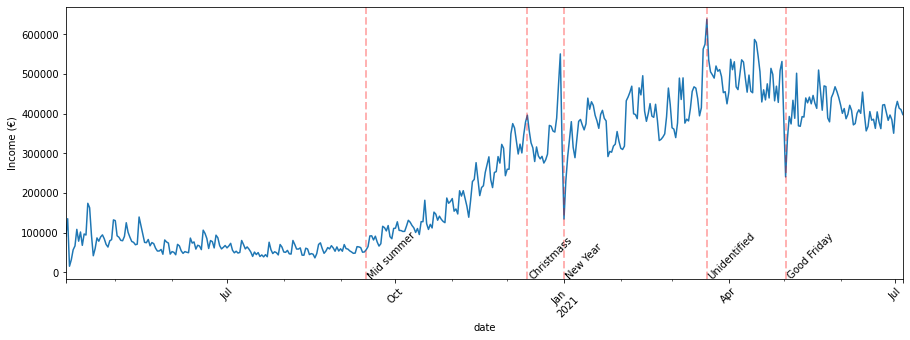

In [5]:
fig, ax= plt.subplots(figsize=(15, 5))
data.groupby("date").income.sum().plot(legend=False, ax=ax)
special_days = [
    ('2021-01-01', 'New Year'),
    ('2020-09-15', 'Mid summer'),
    ('2021-03-20', 'Unidentified'),
    ('2020-12-12', 'Christmass'),
    ('2021-05-02', 'Good Friday'),
]

for day, label in special_days:
    ax.axvline(day, color="red", linestyle="--", alpha=0.3, lw=2, label=label)
    transform = ax.get_xaxis_transform()
    plt.text(day, 0., label, rotation=45, transform=transform)

ax.set_ylabel("Income (€)")
ax.tick_params(axis="x", rotation=45)
;

First, we want to check if the day in the month is relevant. We will plot the mean value for the different days.

''

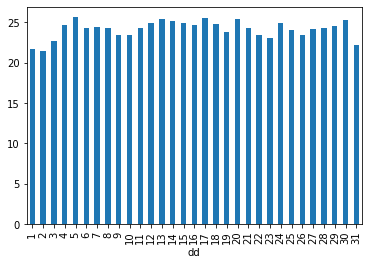

In [6]:
data['dd'] = data['date'].dt.day
ax = data.groupby('dd').income.mean().plot.bar()
ax.tick_params(axis="x", rotation=90)
;

We see that there is no outlier in terms of day of the month, except for the 1st and the 31th. We attribute this to the effect due to the drop in sales on New Year.

The next insight is to see the weekly behaviour.

''

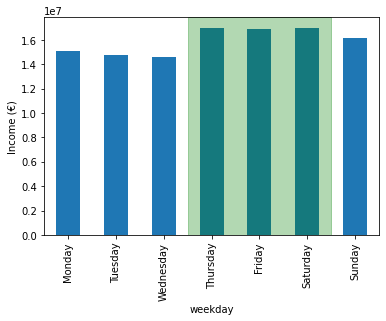

In [7]:
ax = data.groupby('weekday').income.sum().plot.bar()
ax.axvspan(2.5, 5.5, color="green", alpha=0.3)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Income (€)")
;

We see that, marginally, the sales increase on Thursday to Saturday.

# Discriminating over different products

Next, we take a deeper look at the different products. First of all, we analyze the sales separated by product group.

''

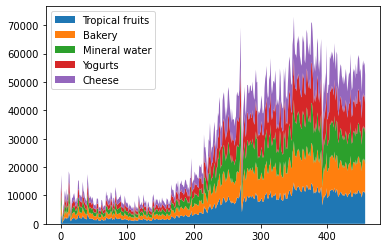

In [8]:
x = data.date.unique()
x = list(range(len(x)))

y = []
legend = []
for group in data.Group.unique():
    sku_sales = data[data['Group'] == group]
    sku_sales = data.groupby('date').sales.sum()
    y.append(sku_sales)
    legend.append(group)

plt.stackplot(x, y, labels=legend, linewidth=0)
plt.legend(loc="upper left")
;

We see that the different groups, at first glance, have a similar weight in the total sales.

As no group is specially dominant, we will analyze if the products income behaves similarly.

''

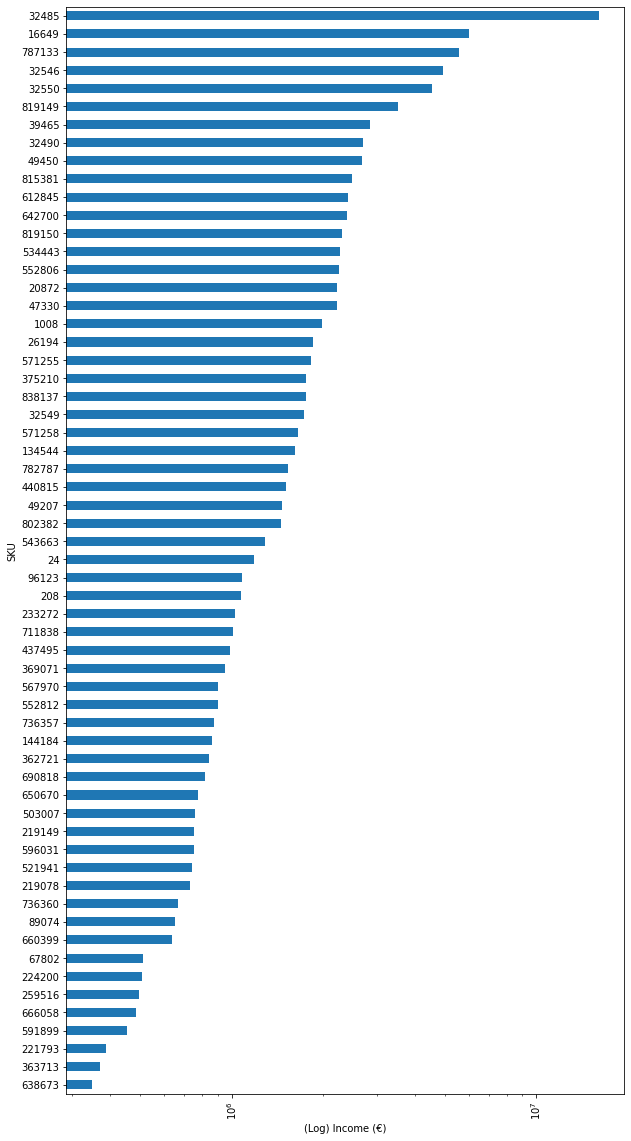

In [ ]:
ax = data.groupby('SKU').income.sum().sort_values().plot.barh(figsize=(10, 20))
ax.tick_params(axis="x", rotation=90)
ax.set_xscale("log")
ax.set_xlabel("(Log) Income (€)")
;

As we can see, the products weight in the total income grows exponentially (note the logarithmic scale). This means that few products account for most of the income.

Below we also identify this behaviour in the categories.

''

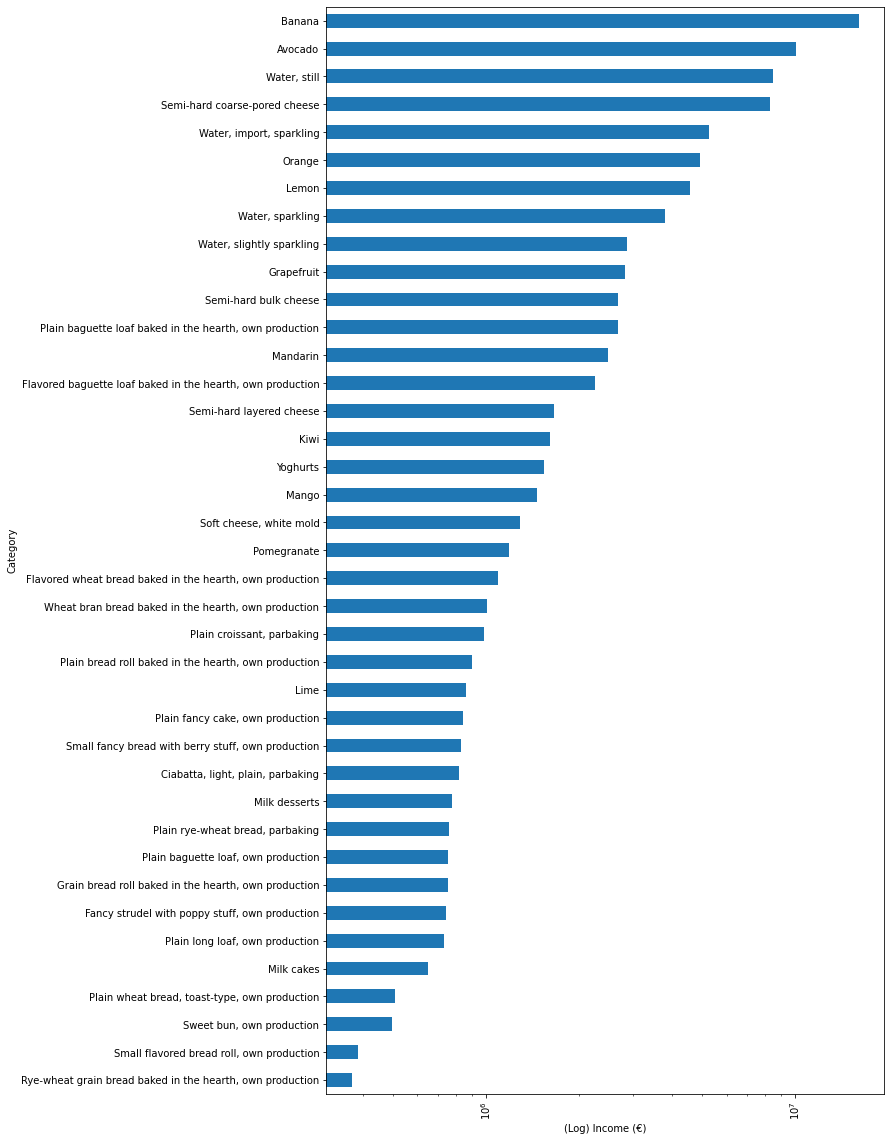

In [ ]:
ax = data.groupby('Category').income.sum().sort_values().plot.barh(figsize=(10, 20))
ax.tick_params(axis="x", rotation=90)
ax.set_xscale("log")
ax.set_xlabel("(Log) Income (€)")
;

Finally, we plot the weight over the total sales and income for each group. As expected, both have the same order, but it's interesting to see that the tropical fruits income stands out, thing that does not happen in the sales volumen.

''

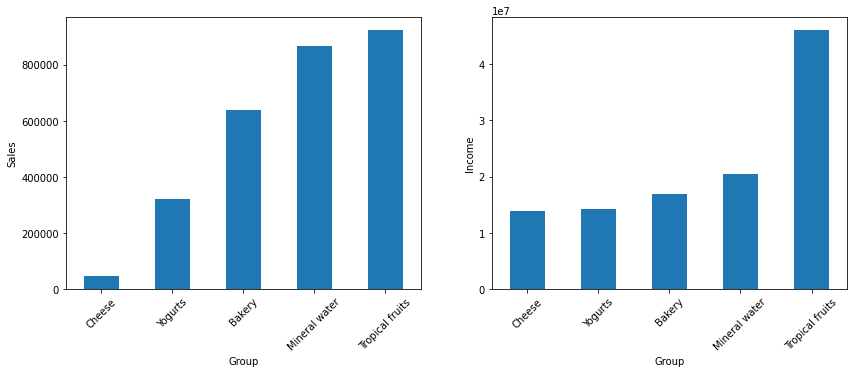

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

data.groupby('Group').sales.sum().sort_values().plot.bar(ax=axes[0])
axes[0].tick_params(axis="x", rotation=45)
axes[0].set_ylabel("Sales")

data.groupby('Group').income.sum().sort_values().plot.bar(ax=axes[1])
axes[1].tick_params(axis="x", rotation=45)
axes[1].set_ylabel("Income")
;

We saw before that the thursday, friday, and saturday incomes. TODOOOOOoo

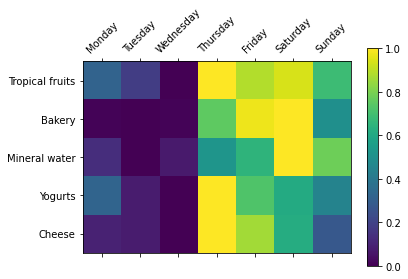

In [12]:
sales_by_day = data.sort_values(['weekday'])
sales_by_day = sales_by_day.groupby(['Group', 'weekday']).sales.sum()

groupings = []
names = []

for gr in data.Group.unique():
    sales_gr = sales_by_day[gr]
    sales_gr = (sales_gr-sales_gr.min())
    sales_gr /= (sales_gr.max() - sales_gr.min())
    groupings.append(sales_gr)
    names.append(gr)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(groupings), vmin=0, vmax=1)
fig.colorbar(cax)

ax.set_xticks(list(range(len(days))))
ax.set_yticks(list(range(len(names))))
ax.set_xticklabels(days)
ax.set_yticklabels(names)
ax.tick_params(axis="x", rotation=45)
plt.show()

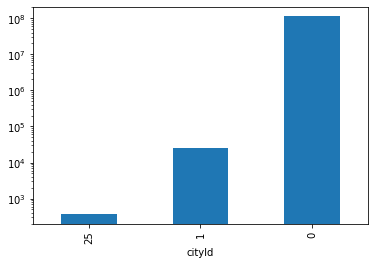

In [13]:
ax = data.groupby('cityId').income.sum().sort_values().plot.bar()
ax.tick_params(axis="x", rotation=90)
ax.set_yscale('log')

<AxesSubplot:xlabel='cityId'>

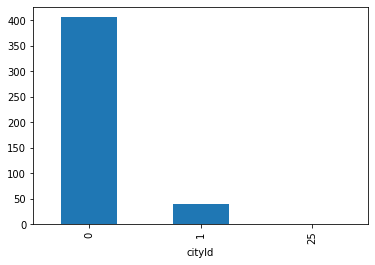

In [14]:
clusters_city = data.groupby(['cityId', 'geoCluster']).size().reset_index().groupby('cityId').size()
clusters_city.plot.bar()

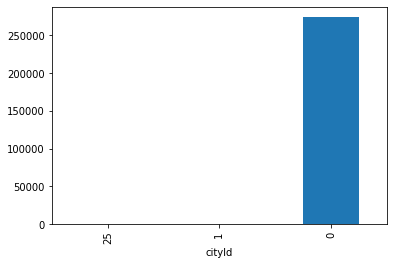

In [15]:
data_income_per_cluster = data.groupby('cityId').income.sum()
data_income_per_cluster /=  clusters_city
ax = data_income_per_cluster.sort_values().plot.bar()
ax.tick_params(axis="x", rotation=90)

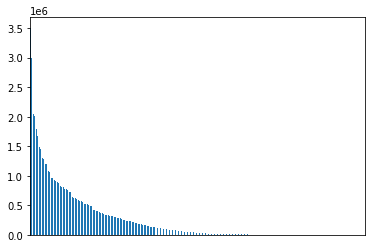

In [16]:
ax = data.groupby('geoCluster').income.sum().sort_values(ascending=False).plot.bar()
ax.tick_params(axis="x", rotation=90)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

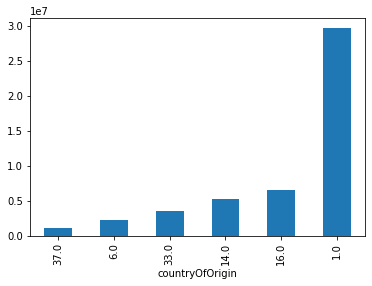

In [17]:
ax = data.groupby('countryOfOrigin').income.sum().sort_values().plot.bar()
ax.tick_params(axis="x", rotation=90)